In [51]:
using DifferentialEquations
using Distributions
using StatsBase
using LinearAlgebra
using PyPlot; const plt = PyPlot
PyPlot.matplotlib.style.use("./paper.mplstyle");

include("utils.jl")
include("kernels.jl")
include("block_delay_kernel.jl")
include("erlang_sum_kernel.jl");

# Kernels

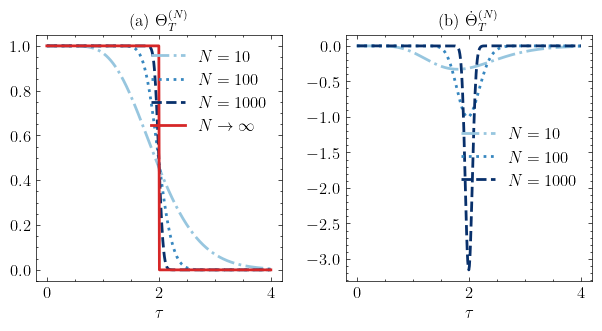

In [2]:
T = 2
τ_range = 0:0.01:2*T
fig, (axl, axr) = plt.subplots(nrows = 1, ncols = 2, figsize = (7.2, 3.2))
axl.plot(
    τ_range, Θ_ker.(τ_range, T, 10),
    label = L"N = 10", color = plt.get_cmap("Blues")(100),
    linestyle = "-."
)
axl.plot(
    τ_range, Θ_ker.(τ_range, T, 100),
    label = L"N = 100", color = plt.get_cmap("Blues")(170),
    linestyle = ":"
)
axl.plot(
    τ_range, Θ_ker.(τ_range, T, 1000),
    label = L"N = 1000", color = plt.get_cmap("Blues")(255),
    linestyle = "--"
)
axl.plot(
    τ_range, Θ.(τ_range, T),
    label = L"N \to \infty", color = "tab:red"
)
axl.legend()

axr.plot(
    τ_range, -Kₘ.(τ_range, T/10, 10)/T,
    label = L"N = 10", color = plt.get_cmap("Blues")(100),
    linestyle = "-."
)
axr.plot(
    τ_range, -Kₘ.(τ_range, T/100, 100)/T,
    label = L"N = 100", color = plt.get_cmap("Blues")(170),
    linestyle = ":"
)
axr.plot(
    τ_range, -Kₘ.(τ_range, T/1000, 1000)/T,
    label = L"N = 1000", color = plt.get_cmap("Blues")(255),
    linestyle = "--"
)
axr.legend()

axl.set(
    xlabel = L"\tau",
    box_aspect = 1,
    title = L"\text{(a) }\Theta_T^{(N)}"
)
axr.set(
    box_aspect = 1,
    xlabel = L"\tau",
    title = L"\text{(b) }\dot{\Theta}_T^{(N)}"
    # title = L"\text{(b) }\mathrm{d}\Theta_T^{(N)} / \mathrm{d}\tau"
)
display(fig)

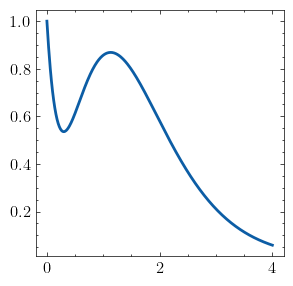

In [119]:
fig, ax = plt.subplots()
T = 2; N = 4
f(τ) = (Kₘ(τ, T/N, 1) - Kₘ(τ, T/N, 2) + 3 * Kₘ(τ, T/N, 3) + 1 * Kₘ(τ, T/N, 4)) * T / N
x = 0:0.01:2*T
ax.plot(x, f(x))
display(fig)

# SIRS time delay system with block delay kernel (Hethcote et al. 1981)

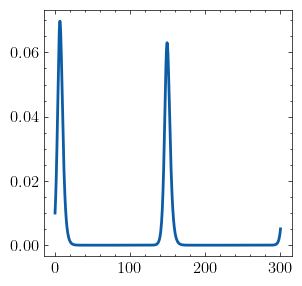

In [3]:
p = (β, ρ, T) = (1.5, 1., 100.)
I₀ = 0.01
sol = solve_step_function_kernel(p..., I₀, 300)

fig, ax = plt.subplots()
ax.plot(sol.t, sol[1, :])
# ax.plot(sol.t, sol[2, :])
display(fig)

# Block delay kernel as Erlang Kernel sum

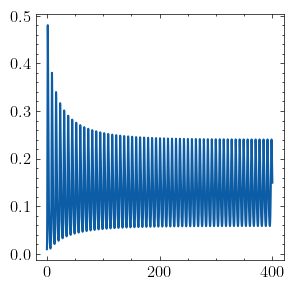

sol[1, end] = 0.1494727925981028
(erlang_sum_kernel_R(sol))[end] = 0.7444746854041233


In [42]:
p = (β, ρ, T, N) = (5, 1, 5, 400)
I₀ = 0.01
t_max = 400
sol = solve_erlang_sum_kernel(β, ρ, T, N, I₀, t_max)

fig, ax = plt.subplots()
ax.plot(sol.t, sol[1, :])
# ax.plot(sol.t, erlang_sum_kernel_R(sol))
display(fig)
@show sol[1, end];
@show erlang_sum_kernel_R(sol)[end];

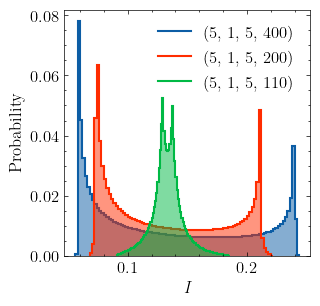

In [52]:
# parameters (β, ρ, T, N)
parameter_sets = [(5, 1, 5, 400), (5, 1, 5, 200), (5, 1, 5, 110)]
I₀ = 0.01
t_max = 2000; t_trans = 200

fig, ax = plt.subplots()
for p in parameter_sets
    sol = solve_erlang_sum_kernel(p..., I₀, t_max)
    hist = normalized_sol_hist(sol, 1, t_trans, t_max)
    ax.set(xlabel = L"I", ylabel = "Probability", box_aspect = 1)
    ax.stairs(hist.weights, hist.edges[1], label = repr(p))
    ax.fill_between(hist.edges[1][1:end-1], hist.weights, alpha = 0.5, step = "post")
end
ax.legend()
display(fig)

## Eigenvalues

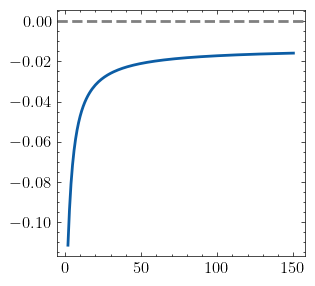

In [135]:
Ns = 2:150
p = (β, ρ, T) = (2, 1, 7)

fig, ax = plt.subplots()
ax.axhline(0.0, ls = "--", c = "gray")
ax.plot(Ns, map(N -> _λ_max(p..., N), Ns))
display(fig)

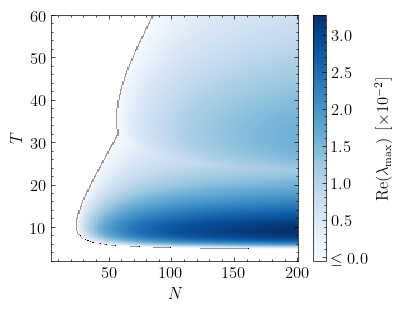

sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


In [147]:
Ns = 5:1:200
Ts = 2:0.1:60
β, ρ = 5, 1

# https://groups.google.com/g/julia-users/c/83Pfg9HGhGQ/m/9G_0wi-GBQAJ
z = [_λ_max(β, ρ, T, N) for T in Ts, N in Ns]
sign_change = (diff(sign.(z), dims=1) .!= 0)[:, 1:end-1] + (diff(sign.(z), dims=2) .!= 0)[1:end-1, :]

fig, ax = plt.subplots(figsize = (4, 3.2))
ax.set(box_aspect = 1, xlabel = L"N", ylabel = L"T")
# Heatmap
hm_cmap = plt.cm.Blues.copy()
hm_cmap.set_under("white")
z_scaled = z ./ 10^(-2)
hm = ax.pcolormesh(Ns, Ts, z_scaled,
                   cmap = hm_cmap, vmin=0)
# Colorbar
cbar = plt.colorbar(hm)
cbar.ax.set(ylim = (-(maximum(z_scaled) - minimum(z_scaled))/1000, maximum(z_scaled)))
cbar_labels = [label.get_text() for label in cbar.ax.get_yticklabels()]
cbar_labels[2] = L"\leq 0.0"
cbar.ax.set_yticklabels(cbar_labels)
cbar.set_label(L"\operatorname{Re}(\lambda_\mathrm{max}) \: \left[\times 10^{-2}\right]", rotation=90)
# Border -- TODO
border_cmap = plt.cm.Greys.copy()
border_cmap.set_under(alpha = 0)
ax.pcolormesh(Ns, Ts, sign_change, cmap=border_cmap, vmin=10^(-10))
display(fig)